In [4]:
from ast import walk
import numpy as np
import pandas as pd
import torch
import random
import scipy.io as sio
from torch.utils.data import Dataset, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
import argparse
import vaegan_models as model
from config import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# set the random seed
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = False

same_seeds(2000)
# torch.cuda.set_device('cuda:1')

# parser = argparse.ArgumentParser(description="make_mat")
# parser.add_argument("--model_type", type=str, default="cvae")
# parser.add_argument("--dataset", type=str, default="AWA2")
# parser.add_argument("--E_path", type=str)
# args = parser.parse_args()



class args:
    model_type = 'cvae'
    dataset = "AWA2"
    E_path = "method4/checkpoints/AWA2/2022-06-17_03-50-33_cvae/E_184.pth"


# data config
dataset = args.dataset
model_type = args.model_type # 'cvae' or 'vae'

config['dataset'] = dataset
config['model_type'] = model_type

# global_path = "/home/csie2020/p76091543/Plearning_song/"
# this_path = "/home/csie2020/p76091543/VAE_Project/"
home_dir = os.path.expanduser("~")

# global_path is plearning path
global_path = os.path.join(home_dir, 'Plearning_song/')
gan_path = os.path.join(home_dir, "VAEGAN_Project/")

if home_dir == "/home/csie2020/p76091543":
    dataset_path = os.path.join(global_path, "data/")
else:
    dataset_path = "/SSD/song/"

dataset_path = os.path.join(global_path, "data/")

model_mat_path = gan_path + f'mat/{dataset}/resnet.mat'
attr_mat_path = gan_path + f'mat/{dataset}/attr.mat'
print('model_mat_path:', model_mat_path)
print('attr_mat_path:', attr_mat_path)



# classname = pd.read_csv(
#     f'{global_path}/data/{dataset}/classes.txt', header=None, sep='\t')
classname = pd.read_csv(
    dataset_path + f'/{dataset}/classes.txt', header=None, sep='\t')

if config['dataset'] == 'SUN':
    config['attr_dim'] = 102
    config['latent_dim'] = 102
    config['class_num'] = 717
    config['seen_class_num'] = 645
    config['unseen_class_num'] = 72
elif config['dataset'] == 'CUB':
    config['attr_dim'] = 312
    config['latent_dim'] = 312
    config['class_num'] = 200
    config['seen_class_num'] = 150
    config['unseen_class_num'] = 50
elif config['dataset'] == 'AWA2':
    config['attr_dim'] = 85
    config['latent_dim'] = 85
    config['class_num'] = 50
    config['seen_class_num'] = 40
    config['unseen_class_num'] = 10



total_class_num = config['seen_class_num'] + config['unseen_class_num']
print(config['dataset'])
resnet101_path = 'resnet_direct_2048/'

npy_path = global_path + f"mat_and_model/{dataset}/npy_file/" + resnet101_path
# model_mat_path = global_path + f"mat_and_model/{dataset}/" + "two_phase/mat/res_direct_2048.mat"
# attr_mat_path = global_path + f"mat_and_model/{dataset}/" + "two_phase/mat/res_attr_direct_2048.mat"

train_dir = f'{dataset_path}' + f'{dataset}/IMG_backoff/train'
val_dir = f'{dataset_path}' + f'{dataset}/IMG_backoff/val'
test_dir = f'{dataset_path}' + f'{dataset}/IMG_backoff/test'
image_size = 224


# Load npy files
data_train = np.load(npy_path + 'train/train_feature_ft.npy')
attr_train = np.load(npy_path + 'train/train_attr_cms.npy')
label_train = np.load(npy_path + 'train/train_label_list.npy')
print('train')
print(data_train.shape)
print(attr_train.shape)
print(label_train.shape)

data_val = np.load(npy_path + 'val/val_feature_ft.npy')
attr_val = np.load(npy_path + 'val/val_attr_cms.npy')
label_val = np.load(npy_path + 'val/val_label_list.npy')
print('val')
print(data_val.shape)
print(attr_val.shape)
print(label_val.shape)

data_test = np.load(npy_path + 'test/test_feature_ft.npy')
attr_test = np.load(npy_path + 'test/test_attr_cms.npy')
label_test = np.load(npy_path + 'test/test_label_list.npy')




class CustomTensorDataset(TensorDataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        x = self.data[index]
        return x
    
    def __init__(self):
        return len(self.data)



print('#############################################')
# make class
seen_class = next(os.walk(train_dir))[1]
unseen_class = next(os.walk(test_dir))[1]

seen_class.sort()
unseen_class.sort()

print(seen_class)
print(unseen_class)


def make_average_attr(data, label, class_num, predict_attr):
    """
    data: visual feature
    label: label
    class_num: number of classes(e.g. seen num or unseen num)
    predict_attr: semantic embedding
    """
    # predict_attr = model(data)
    sum_attr = [[] for i in range(class_num)]
    count_class = [0 for i in range(class_num)]
    # print('class_name: ', class_num)

    for idx in range(len(predict_attr)):
        l = label[idx]
        if len(sum_attr[l]) == 0:
            sum_attr[l] = predict_attr[idx]
        else:
            sum_attr[l] += predict_attr[idx]
        
        count_class[l] += 1
    
    for i in range(class_num):
        sum_attr[i] = sum_attr[i] / count_class[i]
    
    return np.array(sum_attr)



def assign_attr(seen_class, unseen_class, seen_attr, unseen_attr, total_class_num):
    """
    seen_class: seen classes
    unseen_class: unseen classes
    seen_attr: new average seen attribute
    unseen_attr: new average unsen attribute
    total_class_num: number of total classes(e.g. seen + unseen)
    """
    all_attr = [[] for _ in range(total_class_num)]

    seen_idx = 0
    for v, k in enumerate(seen_class):
        idx = np.where(classname[1] == k)
        all_attr[idx[0][0]] = seen_attr[seen_idx]
        seen_idx += 1
    
    unseen_idx = 0
    for v, k in enumerate(unseen_class):
        idx = np.where(classname[1] == k)
        all_attr[idx[0][0]] = unseen_attr[unseen_idx]
        unseen_idx += 1
    
    return np.array(all_attr)


def convert_dict(seen_class, unseen_class):
    seen_convert_dict = {}
    for v, k in enumerate(seen_class):
        idx = np.where(classname[1] == k)
        seen_convert_dict[v] = idx[0][0]
    
    unseen_convert_dict = {}
    for v, k in enumerate(unseen_class):
        idx = np.where(classname[1] == k)
        unseen_convert_dict[v] = idx[0][0]
        
    return seen_convert_dict, unseen_convert_dict

def correct_label(label, convert_dict):
    for idx in range(len(label)):
        l = label[idx]
        label[idx] = convert_dict[l]
    
    return label


trainer = model.TrainerGAN(config)
# E_path = gan_path + "checkpoints/2022-06-12_05-07-18_cvae/E_249.pth"
E_path = gan_path + args.E_path
model = trainer.inference

# model = torch.load(f"vae_pt/{dataset}/best_model.pt")
# elif model_type == 'cvae':
#     model = torch.load('vae_pt/best_model_cvae.pt')

seen_data = torch.from_numpy(data_train).to(device)
unseen_data = torch.from_numpy(data_test).to(device)


if model_type == 'vae':
    _, seen_mu, _ = model(seen_data)
    _, unseen_mu, _ = model(unseen_data)
elif model_type == 'cvae':
    attr_train_tmp = attr_train
    attr_test_tmp = attr_test
    # attr_train_tmp.astype(float)
    # attr_test_tmp.astype(float)
    origin_seen_attr = torch.from_numpy(attr_train_tmp).float().to(device)
    origin_unseen_attr = torch.from_numpy(attr_test_tmp).float().to(device)
    # _, seen_mu, _ = model(E_path, seen_data, origin_seen_attr)
    # _, unseen_mu, _ = model(E_path, unseen_data, origin_unseen_attr)
    seen_mu = model(E_path, seen_data, origin_seen_attr)
    unseen_mu = model(E_path, unseen_data, origin_unseen_attr)


seen_mu = seen_mu.cpu().detach().numpy()
seen_attr = make_average_attr(data_train, label_train, config['seen_class_num'], seen_mu)

unseen_mu = unseen_mu.cpu().detach().numpy()
unseen_attr = make_average_attr(data_test, label_test, config['unseen_class_num'], unseen_mu)

# all_attr = assign_attr(seen_class, unseen_class, seen_attr, unseen_attr, total_class_num)
# seen_convert_dict, unseen_convert_dict = convert_dict(seen_class, unseen_class)


# converted_label_train = correct_label(label_train, seen_convert_dict)
# converted_label_val = correct_label(label_val, seen_convert_dict)
# converted_label_test = correct_label(label_test, unseen_convert_dict)



# data = np.concatenate((data_train, data_val, data_test), axis=0)
# label = np.concatenate((converted_label_train, converted_label_val, 
#                         converted_label_test), axis=0)


def mat_list(data, label):
    data_list = []
    label_list = []
    trainval_loc = []
    test_seen_loc = []
    test_unseen_loc = []

    for i in range(len(data)):
        data_list.append(data[i])
        label_list.append(label[i] + 1)
        if i < len(data_train):
            trainval_loc.append(i+1)
        elif i < len(data_train) + len(data_val) and i >= len(data_train):
            test_seen_loc.append(i+1)
        elif i < len(data_train) + len(data_val) + len(data_test) and i >= len(data_train) + len(data_val):
            test_unseen_loc.append(i+1)
        
    data_list = np.row_stack(data_list)
    label_list = np.row_stack(label_list)
    trainval_loc = np.row_stack(trainval_loc)
    test_seen_loc = np.row_stack(test_seen_loc)
    test_unseen_loc = np.row_stack(test_unseen_loc)

    return data_list, label_list, trainval_loc, test_seen_loc, test_unseen_loc

# data_list, label_list, trainval_loc, test_seen_loc, test_unseen_loc = mat_list(data, label)





# attr_tsne = TSNE(n_components=2, init='random', perplexity = 50,n_iter= 3000,verbose=1).fit_transform(seen_mu)

# plt.figure(figsize=(8, 8))
# for i in range(attr_tsne.shape[0]):
#     plt.text(attr_tsne[i, 0], attr_tsne[i, 1],str(label_test[i]),color=plt.cm.Set2(label_test[i]), 
#              fontdict={'weight': 'bold', 'size': 9})
# plt.xticks([])
# plt.yticks([])
# plt.savefig('seen_tsne')


attr_tsne = TSNE(n_components=2, init='random', perplexity = 50,n_iter= 3000,verbose=1).fit_transform(unseen_mu)



model_mat_path: /home/csie2020/p76091543/VAEGAN_Project/mat/AWA2/resnet.mat
attr_mat_path: /home/csie2020/p76091543/VAEGAN_Project/mat/AWA2/attr.mat
AWA2
train
(24264, 2048)
(24264, 85)
(24264,)
val
(6070, 2048)
(6070, 85)
(6070,)
#############################################
['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'collie', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'fox', 'german+shepherd', 'giraffe', 'gorilla', 'grizzly+bear', 'hamster', 'horse', 'killer+whale', 'lion', 'mole', 'moose', 'mouse', 'otter', 'ox', 'polar+bear', 'rabbit', 'rhinoceros', 'sheep', 'siamese+cat', 'skunk', 'spider+monkey', 'squirrel', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']
['chimpanzee', 'giant+panda', 'hippopotamus', 'humpback+whale', 'leopard', 'persian+cat', 'pig', 'raccoon', 'rat', 'seal']


/home/csie2020/p76091543/anaconda3/envs/pytorch_11_1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6984 samples in 0.001s...
[t-SNE] Computed neighbors for 6984 samples in 1.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6984
[t-SNE] Computed conditional probabilities for sample 2000 / 6984
[t-SNE] Computed conditional probabilities for sample 3000 / 6984
[t-SNE] Computed conditional probabilities for sample 4000 / 6984
[t-SNE] Computed conditional probabilities for sample 5000 / 6984
[t-SNE] Computed conditional probabilities for sample 6000 / 6984
[t-SNE] Computed conditional probabilities for sample 6984 / 6984
[t-SNE] Mean sigma: 0.096642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.716713
[t-SNE] KL divergence after 3000 iterations: 1.412511


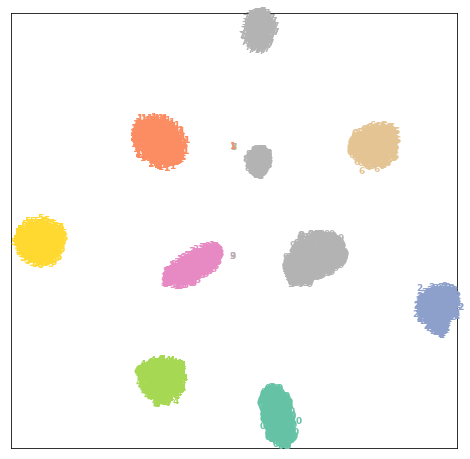

In [6]:
attr_min, attr_max = attr_tsne.min(0), attr_tsne.max(0)
attr_norm = (attr_tsne - attr_min) / (attr_max - attr_min)  #Normalize
plt.figure(figsize=(8, 8))
for i in range(attr_norm.shape[0]):
    plt.text(attr_norm[i, 0], attr_norm[i, 1],str(label_test[i]),color=plt.cm.Set2(label_test[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig('unseen_tsne.png')